# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [32]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [33]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [34]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [35]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [36]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [37]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [38]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [39]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [40]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [41]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [42]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [43]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [44]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [45]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [46]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [47]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [48]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [49]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [50]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [51]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [52]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:49<00:00, 1763.07it/s]


In [53]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

 75%|█████████████████████████████████████████████████████████▎                  | 7217/9564 [00:03<00:01, 1944.03it/s]C:\Users\rites\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:04<00:00, 2223.31it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [34]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [35]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [26]:
# Train your own Word2Vec model using your own text corpus
list_of_sentance=[]
for sentance in tqdm(preprocessed_reviews):
    list_of_sentance.append(sentance.split())

100%|██████████| 87773/87773 [00:01<00:00, 67330.64it/s]


In [28]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.7899521589279175), ('awesome', 0.7837361097335815), ('excellent', 0.7781263589859009), ('good', 0.7477326393127441), ('wonderful', 0.7256789803504944), ('terrific', 0.7150567173957825), ('fabulous', 0.638457179069519), ('nice', 0.6307187080383301), ('amazing', 0.6291524171829224), ('perfect', 0.6279327273368835)]
[('greatest', 0.7678017616271973), ('tastiest', 0.7277802228927612), ('best', 0.7024060487747192), ('nastiest', 0.6937783360481262), ('smoothest', 0.6146581768989563), ('disgusting', 0.6086519956588745), ('horrible', 0.6018313765525818), ('awful', 0.595213770866394), ('terrible', 0.590133547782898), ('closest', 0.5851168036460876)]


In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['deal', 'cuisinart', 'ding', 'shinier', 'das', 'toothbrushes', 'periodically', 'ie', 'dinosaur', 'lettuce', 'nuts', 'oily', 'bird', 'grabs', 'missouri', 'rude', 'differing', 'garnishes', 'set', 'calmer', 'remover', 'boasts', 'neo', 'bai', 'decorate', 'prebiotics', 'collector', 'copies', 'bellagio', 'cringed', 'touching', 'axe', 'roland', 'pups', 'sweetners', 'specifies', 'support', 'nip', 'lessons', 'mee', 'madras', 'guava', 'goodbye', 'catagory', 'dialed', 'shorter', 'hearted', 'investigated', 'kcal', 'mold']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [29]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 87773/87773 [22:15<00:00, 63.98it/s] 

87773
200


#### [4.4.1.2] TFIDF weighted W2v

In [30]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [52:51<00:00, 27.68it/s]  


In [25]:
# Function to plot confusion matrix
def confusion_matrix_plot(test_y, predict_y):
    # C stores the confusion matrix 
    C = confusion_matrix(test_y, predict_y)
    
    # Class labels 
    labels_x = ["Predicted No","Predicted Yes"]
    labels_y = ["Original No","Original Yes"]
    
    cmap=sns.light_palette("orange")
    print("Confusion matrix")
    plt.figure(figsize=(4,4))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.show()

In [26]:
# Function to plot roc curve

def plot_roc_curve(Y_test,predict_y_test,Y_train,predict_y_train):
    fpr1,tpr1,threshold1 = roc_curve(Y_test,predict_y_test) # For test dataset
    fpr2,tpr2,threshold2 = roc_curve(Y_train,predict_y_train) # For train dataset
    
    plt.plot([0,1],[0,1])
    plt.plot(fpr1,tpr1,label="Validation AUC")
    plt.plot(fpr2,tpr2,label="Train AUC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Reciever Operating Characteristics")
    plt.grid()
    plt.legend()
    plt.show()

In [27]:
# Plotting graph of auc and parameter for training and cross validation error
import math
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
alpha1 = [math.log10(i) for i in alpha]
def plot_train_vs_auc(train_auc_list,cv_auc_list):
    plt.plot(alpha1,train_auc_list,label="Train AUC")
    plt.xlabel("Log of Hyper-parameter alpha for regularization")
    plt.ylabel("Area Under Curve")
    plt.plot(alpha1,cv_auc_list,label="Validation AUC")
    plt.title("Train and Validation Area Under Curve")
    plt.grid()
    plt.legend()
    plt.show()

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Splitting data into train and test dataset
bow_vect = CountVectorizer()

X = preprocessed_reviews
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train))
print(len(X_test))

61441
26332


In [55]:
# Vectorizing train and test dataset seperately to prevent data lekage
bow_train_vect = bow_vect.fit_transform(X_train)
bow_test_vect = bow_vect.transform(X_test)
bow_train_vect.shape

(61441, 46115)

In [56]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

C:\Users\rites\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rites\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rites\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


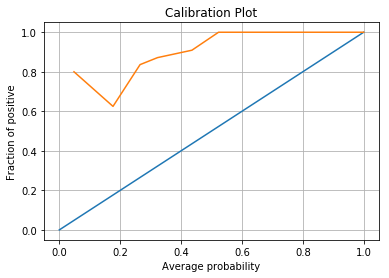

In [65]:
# Taking best value of alpha = 0.0001 an trainig final model
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
# Initializing model
# Initializing the linear SVM classifier
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.01,max_iter=5000)
clf.fit(bow_train_vect,Y_train)

prob = clf.decision_function(bow_test_vect) # this gives the output probability of the svm model.
fop, apv = calibration_curve(Y_test, prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

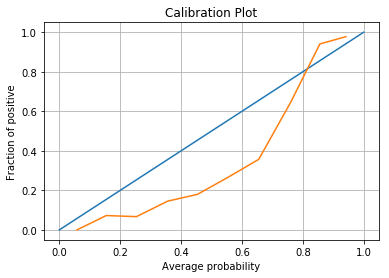

In [66]:
# Taking best value of alpha = 0.0001 an trainig final model
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
# Initializing model
# Initializing the linear SVM classifier
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.01,max_iter=5000)
# using calibrated classifier cv
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
calibrated_model.fit(bow_train_vect,Y_train)

prob = calibrated_model.predict_proba(bow_test_vect)[:,1] # return the probability for positive class
fop, apv = calibration_curve(Y_test, prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

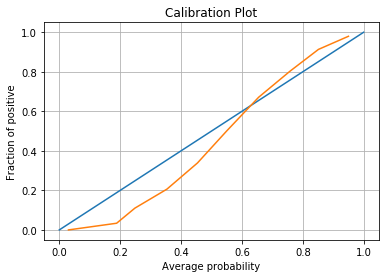

In [67]:
# Taking best value of alpha = 0.0001 an trainig final model

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
# Initializing model
# Initializing the linear SVM classifier
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.01,max_iter=5000)
calibrated_model = CalibratedClassifierCV(clf,method='isotonic',cv=5)
calibrated_model.fit(bow_train_vect,Y_train)

prob = calibrated_model.predict_proba(bow_test_vect)[:,1]
fop, apv = calibration_curve(Y_test, prob, n_bins= 10, normalize=True)

plt.plot([0,1],[0,1])
plt.plot(apv, fop)
plt.grid()
plt.xlabel("Average probability")
plt.ylabel("Fraction of positive")
plt.title("Calibration Plot")
plt.show()

<h3>L1 regularization</h3>

In [54]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l1',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(bow_train_vect,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [03:31<00:00,  9.28s/it]


In [55]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    # If data is imbalenced then giving weights to class improves AUC Score. Here class 0 has 5 times less points than class 1.
    clf = SGDClassifier(penalty='l1',alpha=k,tol=0.001,max_iter=400)#Giving weights for imbalenced data.
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████| 9/9 [17:13<00:00, 45.87s/it] 


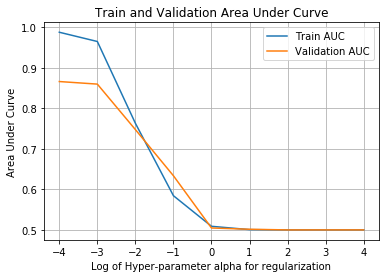

In [57]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [58]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400,class_weight={0:5,1:1})
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
calibrated_model.fit(bow_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(bow_train_vect)
probab_y_train = calibrated_model.predict_proba(bow_train_vect)[:,1]
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for BoW vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for BoW vectorized Linear SVM is 0.876


Confusion Matrix for test data
Confusion matrix


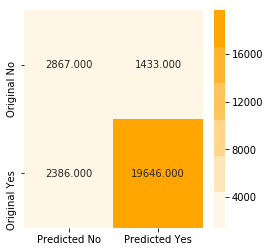

In [59]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


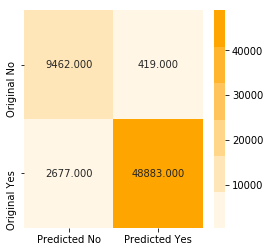

In [60]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

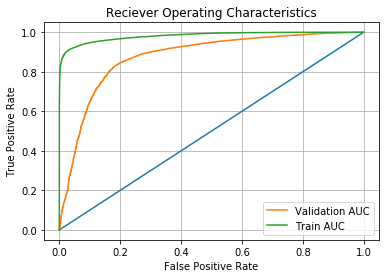

In [61]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using gridsearchcv for hyper parameter tunning</h3>

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l1',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(bow_test_vect,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.8713352574813915
The best alpha(1/C) is  0.0001


In [50]:
# Training final model on alpha=0.0001
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
calibrated_model.fit(bow_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(bow_train_vect)
probab_y_train = calibrated_model.predict_proba(bow_train_vect)[:,1]
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for BoW vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for BoW vectorized Linear SVM is 0.893


Confusion Matrix for test data
Confusion matrix


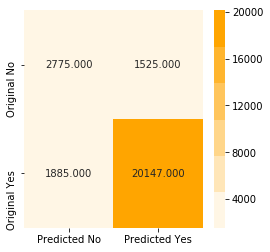

In [51]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


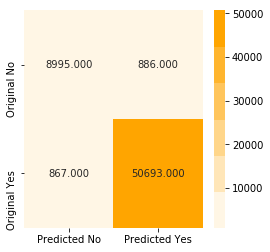

In [52]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

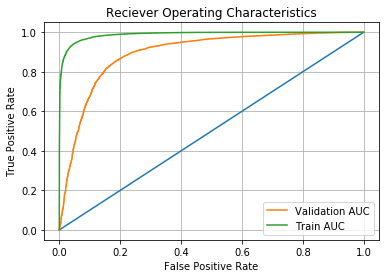

In [53]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>L2 regularization</h3>

In [62]:
param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l2',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(bow_train_vect,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [00:07<00:00,  1.49it/s]


In [63]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l2',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████| 9/9 [00:44<00:00,  3.79s/it]


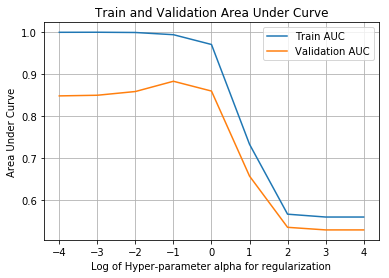

In [64]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [99]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
clf2 = SGDClassifier(penalty='l2',alpha=0.1,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf2,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(bow_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf2.fit(bow_train_vect,Y_train)

predict_y = clf2.predict(bow_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf2.predict(bow_train_vect)
probab_y_train = calibrated_model.predict_proba(bow_train_vect)[:,1]
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for BoW vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for BoW vectorized Linear SVM is 0.905


Confusion Matrix for test data
Confusion matrix


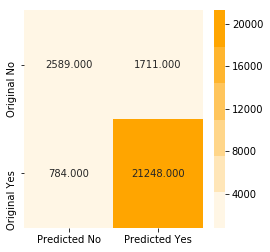

In [92]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


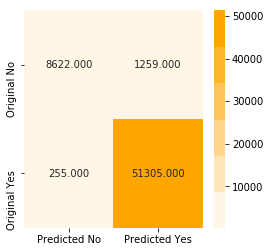

In [93]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

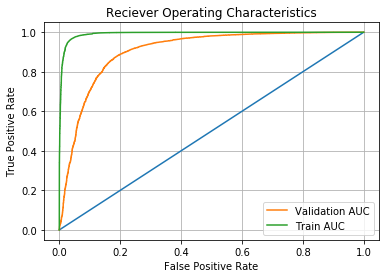

In [94]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using Grid Search Cv to tunr hyper parameters</h3>

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l2',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(bow_test_vect,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.9038812091751481
The best alpha(1/C) is  0.1


In [100]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
clf2 = SGDClassifier(penalty='l2',alpha=0.1,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf2,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(bow_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf2.fit(bow_train_vect,Y_train)

predict_y = clf2.predict(bow_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf2.predict(bow_train_vect)
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for BoW vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for BoW vectorized Linear SVM is 0.905


Confusion Matrix for test data
Confusion matrix


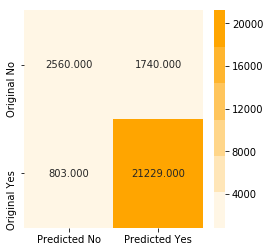

In [101]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


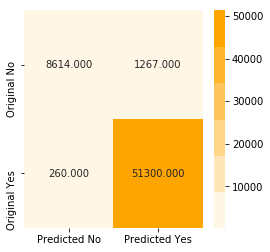

In [102]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

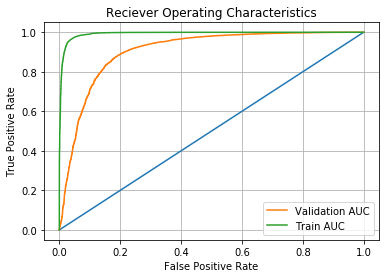

In [103]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Top 10 positive features</h3>

In [77]:
#To get most important features first sort the weight vectors in ascending order and then take last 10 features 
# Corresponding to that index.

# Getting all features from BoW model
all_features = bow_vect.get_feature_names()

# Getting weight vector of features.
weight_vect = clf2.coef_

#Contains the index of all weights in ascending order
top10_pos_feat = weight_vect[0].argsort() 

# Top 10 features 
top10_pos_words = [all_features[i] for i in top10_pos_feat[-10:]]
print(top10_pos_words)

['perfect', 'favorite', 'wonderful', 'excellent', 'loves', 'delicious', 'best', 'love', 'good', 'great']


<h3>Top 10 negative features</h3>

In [78]:
#To get most important features first sort the weight vectors in ascending order and then take last 10 features 
# Corresponding to that index.

#Contains the index of all weights in ascending order
top10_neg_feat = weight_vect[0].argsort() 

# Top 10 features 
top10_neg_words = [all_features[i] for i in top10_neg_feat[0:10]]
print(top10_neg_words)

['not', 'disappointed', 'worst', 'awful', 'terrible', 'horrible', 'disappointing', 'threw', 'disappointment', 'waste']


<h3>Observation</h3>

<h4>1. Linear SVM with l1 as penalty had AUC of 0.883 and False positive = 1437 and False Negative = 2406</h4>
<h4>2. Linear SVM with l2 as penalty had AUC of 0.909 and False positive=1718 and False Negative = 696</h4>
<h4>3. From these results it seems that Linear SVM model with l2 penalty is slightly biased towards positive points.</h4>

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [104]:
# Initializing Tfidf vectorizer
tfidf_vect = TfidfVectorizer()

# Vectorizing train and test dataset seperately to prevent data lekage
tfidf_train_vect = tfidf_vect.fit_transform(X_train)
tfidf_test_vect = tfidf_vect.transform(X_test)
tfidf_train_vect.shape

(61441, 46115)

In [105]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
tfidf_train_vect = std.fit_transform(tfidf_train_vect)
tfidf_test_vect = std.transform(tfidf_test_vect)

<h3>L1 regularization</h3>

In [81]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l1',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(tfidf_train_vect,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(tfidf_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [04:09<00:00, 10.88s/it]


In [82]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l1',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(tfidf_train_vect):
        x_train = tfidf_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = tfidf_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████| 9/9 [17:51<00:00, 47.30s/it] 


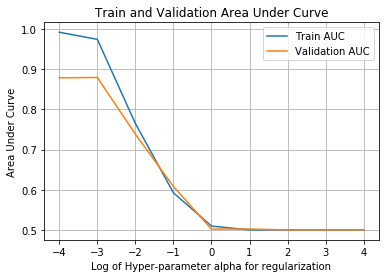

In [83]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [106]:
# Taking best value of alpha = 0.001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(tfidf_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(tfidf_train_vect,Y_train)

predict_y = clf.predict(tfidf_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(tfidf_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(tfidf_train_vect)
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Tfidf vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Tfidf vectorized Linear SVM is 0.896


Confusion Matrix for test data
Confusion matrix


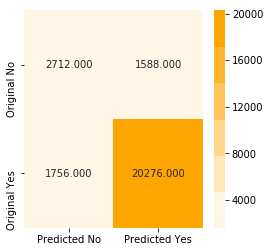

In [107]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


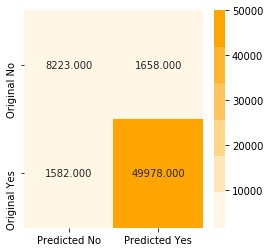

In [108]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

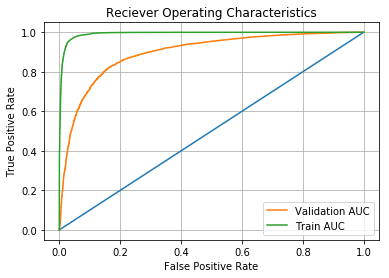

In [109]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using Grid Search CV to tune hyperparameter</h3>

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l1',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(tfidf_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(tfidf_test_vect)
predict_y_train = optimized_clf.predict(tfidf_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(tfidf_test_vect,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.8798799939237429
The best alpha(1/C) is  0.0001


In [114]:
# Taking best value of alpha = 0.001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(tfidf_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(tfidf_train_vect,Y_train)

predict_y = clf.predict(tfidf_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(tfidf_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(tfidf_train_vect)
probab_y_train = calibrated_model.predict_proba(tfidf_train_vect)[:,1]
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Tfidf vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Tfidf vectorized Linear SVM is 0.897


Confusion Matrix for test data
Confusion matrix


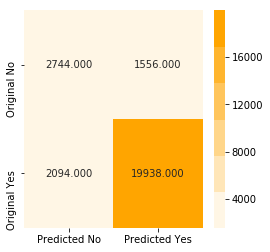

In [115]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


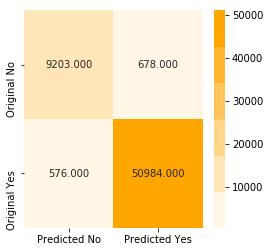

In [116]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

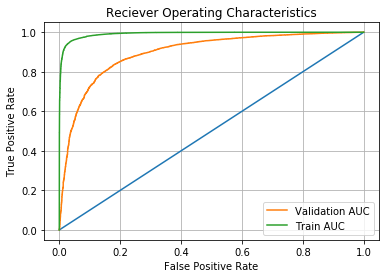

In [117]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>L2 Regularization</h3>

In [118]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l2',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(tfidf_train_vect,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(tfidf_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [00:07<00:00,  1.52it/s]


In [119]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l2',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(tfidf_train_vect):
        x_train = tfidf_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = tfidf_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████| 9/9 [00:38<00:00,  3.49s/it]


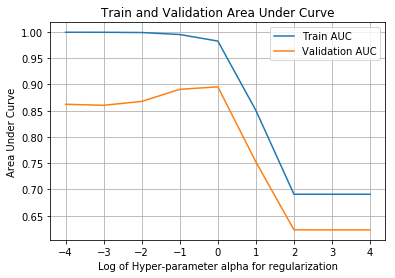

In [120]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [126]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
clf2 = SGDClassifier(penalty='l2',alpha=1,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf2,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(tfidf_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf2.fit(tfidf_train_vect,Y_train)

predict_y = clf2.predict(tfidf_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(tfidf_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf2.predict(tfidf_train_vect)
probab_y_train = calibrated_model.predict_proba(tfidf_train_vect)[:,1]
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Tfidf vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Tfidf vectorized Linear SVM is 0.911


Confusion Matrix for test data
Confusion matrix


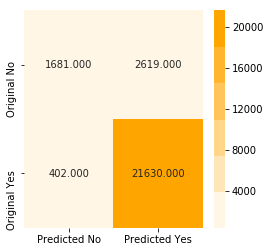

In [127]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


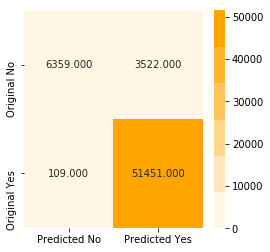

In [128]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

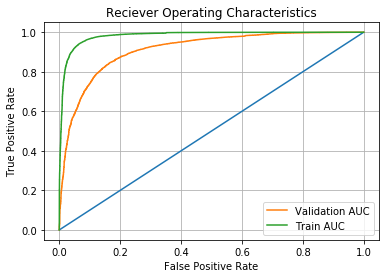

In [129]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using grid search cv</h3>

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l2',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(tfidf_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(tfidf_test_vect)
predict_y_train = optimized_clf.predict(tfidf_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(tfidf_test_vect,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.8998556888956403
The best alpha(1/C) is  0.1


In [130]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
clf2 = SGDClassifier(penalty='l2',alpha=0.1,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf2,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(tfidf_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf2.fit(tfidf_train_vect,Y_train)

predict_y = clf2.predict(tfidf_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(tfidf_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf2.predict(tfidf_train_vect)
probab_y_train = calibrated_model.predict_proba(tfidf_train_vect)[:,1]
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Tfidf vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Tfidf vectorized Linear SVM is 0.912


Confusion Matrix for test data
Confusion matrix


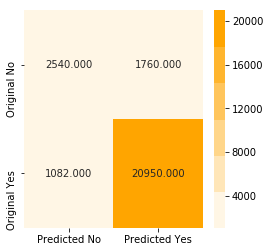

In [131]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y)

Confusion Matrix for train data
Confusion matrix


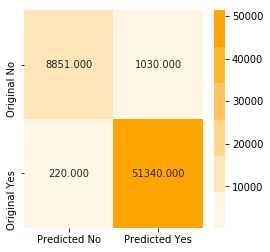

In [132]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

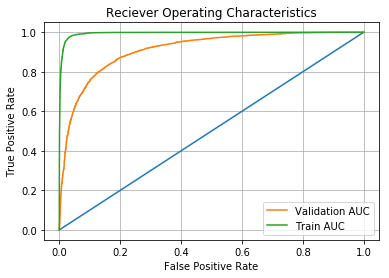

In [133]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Top 10 positive words</h3>

In [134]:
#To get most important features first sort the weight vectors in ascending order and then take last 10 features 
# Corresponding to that index.

# Getting all features from BoW model
all_features = tfidf_vect.get_feature_names()

# Getting weight vector of features
weight_vect = clf2.coef_

#Contains the index of all weights in ascending order
top10_pos_feat = weight_vect[0].argsort() 

# Top 10 features 
top10_pos_words = [all_features[i] for i in top10_pos_feat[-10:]]
print(top10_pos_words)

['wonderful', 'nice', 'perfect', 'loves', 'excellent', 'delicious', 'best', 'love', 'good', 'great']


<h3>Top 10 negative words</h3>

In [135]:
#To get most important features first sort the weight vectors in ascending order and then take last 10 features 
# Corresponding to that index.

#Contains the index of all weights in ascending order
top10_neg_feat = weight_vect[0].argsort() 

# Top 10 features 
top10_neg_words = [all_features[i] for i in top10_neg_feat[0:10]]
print(top10_neg_words)

['not', 'disappointed', 'worst', 'terrible', 'horrible', 'awful', 'disappointing', 'threw', 'disgusting', 'disappointment']


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [33]:
# Splitting list_of_sentance into train and test dataset
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentance,Y,test_size=0.3,random_state=42)
print(len(X_train))

61441


In [ ]:
# Training word2Vec model on traain dataset and will use same for test dataset
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(X_train,min_count=5,size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

In [34]:
# Vectorizing train datset. 
# Train and test dataset are vectorized seperately to prevent d lekage 
# average Word2Vec
# compute average word2vec for each review.
train_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_avg_w2v.append(sent_vec)
print(len(train_avg_w2v))
print(len(train_avg_w2v[0]))

100%|██████████| 61441/61441 [14:14<00:00, 71.88it/s]

61441
200


In [35]:
# Vectorizing test datset. 
# Train and test dataset are vectorized seperately to prevent d lekage 
# average Word2Vec
# compute average word2vec for each review.
test_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_avg_w2v.append(sent_vec)
print(len(test_avg_w2v))
print(len(test_avg_w2v[0]))

100%|██████████| 26332/26332 [06:09<00:00, 71.22it/s]

26332
200


<h3>L1 Regularization</h3>

In [36]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l1',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(train_avg_w2v,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(train_avg_w2v)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [00:26<00:00,  2.86s/it]


In [37]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l1',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_avg_w2v):
        x_train = train_avg_w2v[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_avg_w2v[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████| 9/9 [02:31<00:00, 15.79s/it]


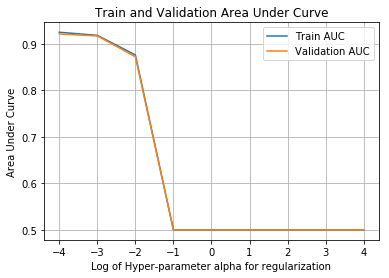

In [38]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [40]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(train_avg_w2v,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(train_avg_w2v,Y_train)

predict_y_test = clf.predict(test_avg_w2v)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(test_avg_w2v)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(train_avg_w2v)
probab_y_train = calibrated_model.predict_proba(train_avg_w2v)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Avg W2V vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Avg W2V vectorized Linear SVM is 0.927


Confusion Matrix for test data
Confusion matrix


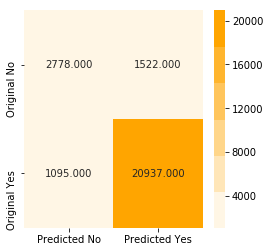

In [42]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


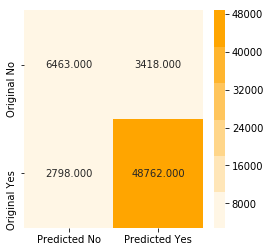

In [43]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

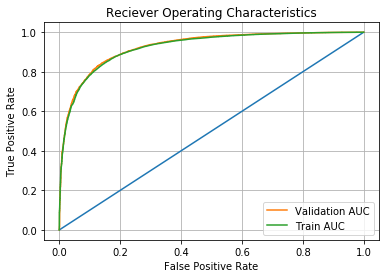

In [44]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using grid search cv</h3>

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l1',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(train_avg_w2v,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(test_avg_w2v)
predict_y_train = optimized_clf.predict(train_avg_w2v)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(test_avg_w2v,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.900919033875133
The best alpha(1/C) is  0.0001


In [46]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(train_avg_w2v,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(train_avg_w2v,Y_train)

predict_y_test = clf.predict(test_avg_w2v)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(test_avg_w2v)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(train_avg_w2v)
probab_y_train = calibrated_model.predict_proba(train_avg_w2v)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Avg W2V vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Avg W2V vectorized Linear SVM is 0.928


Confusion Matrix for test data
Confusion matrix


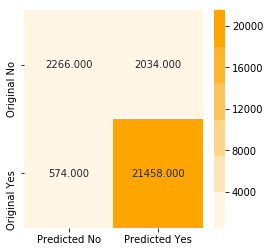

In [47]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


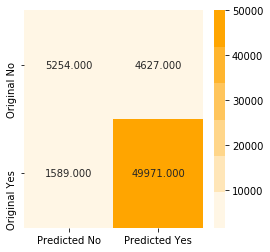

In [49]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

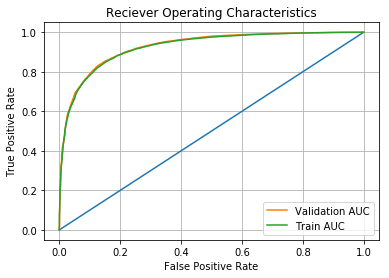

In [50]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>L2 Regularization</h3>

In [55]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l2',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(train_avg_w2v,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(train_avg_w2v)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [00:20<00:00,  2.05s/it]


In [56]:
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l2',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_avg_w2v):
        x_train = train_avg_w2v[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_avg_w2v[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████| 9/9 [01:24<00:00,  8.47s/it]


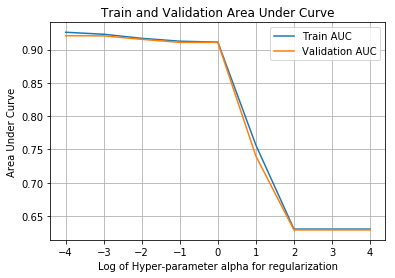

In [57]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [58]:
# Taking best value of alpha = 0.001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(train_avg_w2v,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(train_avg_w2v,Y_train)

predict_y_test = clf.predict(test_avg_w2v)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(test_avg_w2v)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(train_avg_w2v)
probab_y_train = calibrated_model.predict_proba(train_avg_w2v)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Avg W2V vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Avg W2V vectorized Linear SVM is 0.922


Confusion Matrix for test data
Confusion matrix


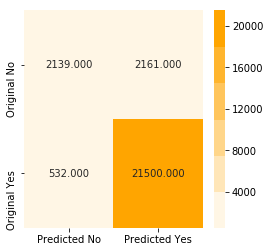

In [59]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


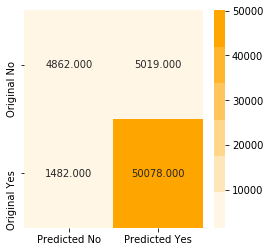

In [60]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

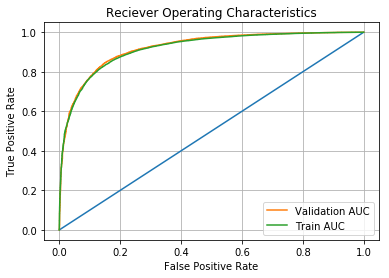

In [61]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using grid search cv</h3>

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l2',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(train_avg_w2v,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(test_avg_w2v)
predict_y_train = optimized_clf.predict(train_avg_w2v)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(test_avg_w2v,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.9008051040559015
The best alpha(1/C) is  0.0001


In [63]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l2',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(train_avg_w2v,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(train_avg_w2v,Y_train)

predict_y_test = clf.predict(test_avg_w2v)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(test_avg_w2v)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(train_avg_w2v)
probab_y_train = calibrated_model.predict_proba(train_avg_w2v)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Avg W2V vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Avg W2V vectorized Linear SVM is 0.928


Confusion Matrix for test data
Confusion matrix


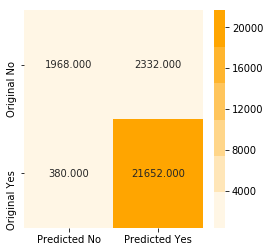

In [64]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


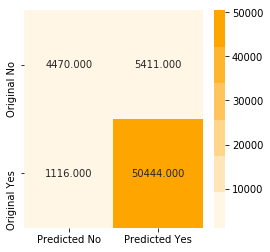

In [65]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

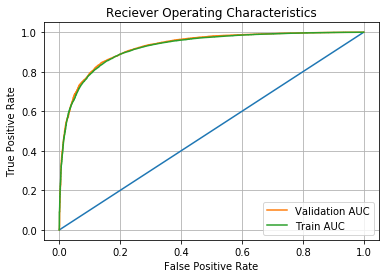

In [66]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [30]:
# Splitting list_of_sentance into train and test dataset
from sklearn.cross_validation import train_test_split
Y = final['Score'] # Labels of datapoints
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)
print(len(X_train))

61441


In [31]:
# Training word2Vec model on traain dataset and will use same for test dataset
w2v_train = []
for sent in X_train:
    w2v_train.append(sent.split())

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(w2v_train,min_count=5,size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8098214268684387), ('awesome', 0.7502527236938477), ('terrific', 0.7415599226951599), ('excellent', 0.7310376763343811), ('wonderful', 0.7199099063873291), ('good', 0.718035876750946), ('amazing', 0.6713637709617615), ('perfect', 0.6362202167510986), ('fabulous', 0.628663182258606), ('nice', 0.5959922075271606)]
[('greatest', 0.7609308362007141), ('best', 0.683108389377594), ('closest', 0.649026095867157), ('disgusting', 0.636695146560669), ('smoothest', 0.6243921518325806), ('nastiest', 0.621765673160553), ('experienced', 0.6001076102256775), ('worse', 0.5816943049430847), ('tastiest', 0.5779926776885986), ('awful', 0.5759199261665344)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14819
sample words  ['shaped', 'spilled', 'stuffing', 'overnight', 'aspen', 'warehouse', 'tv', 'garrett', 'assessment', 'arriba', 'warming', 'sorbitol', 'wasnt', 'prefers', 'vases', 'comparative', 'works', 'corny', 'adds', 'vomit', 'til', 'ruining', 'miss', 'believed', 'lo', 'believes', 'pez', 'feeding', 'automatic', 'devotee', 'chapstick', 'gsugars', 'skinny', 'central', 'agave', 'take', 'pregnancy', 'medleys', 'radish', 'duh', 'converts', 'anticipated', 'gland', 'baconnaise', 'removed', 'repulsed', 'leached', 'stupid', 'douwe', 'zang']


In [33]:
# Fitting on train and will use same for test to prevent data leakage
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [72]:
# TF-IDF weighted Word2Vec for test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 61441/61441 [40:34<00:00, 25.23it/s]  


In [73]:
# TF-IDF weighted Word2Vec for test dataset
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [17:22<00:00, 25.26it/s]


<h3>L1 regularization</h3>

In [74]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l1',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(tfidf_train_sent_vectors,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(tfidf_train_sent_vectors)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [00:09<00:00,  1.00it/s]


In [37]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l1',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(tfidf_train_sent_vectors):
        x_train = tfidf_train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = tfidf_train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████| 9/9 [02:29<00:00, 16.18s/it]


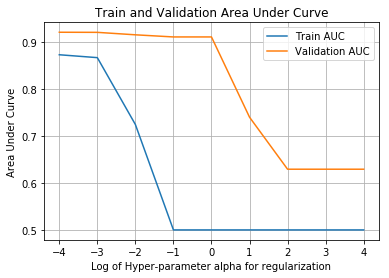

In [75]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [77]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(tfidf_train_sent_vectors,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(tfidf_train_sent_vectors,Y_train)

predict_y_test = clf.predict(tfidf_test_sent_vectors)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(tfidf_test_sent_vectors)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(tfidf_train_sent_vectors)
probab_y_train = calibrated_model.predict_proba(tfidf_train_sent_vectors)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Tfidf weighted avg w2v vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Tfidf weighted avg w2v vectorized Linear SVM is 0.877


Confusion Matrix for train data
Confusion matrix


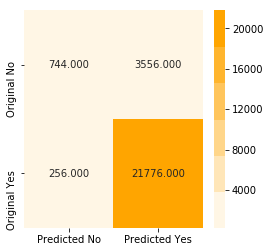

In [78]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


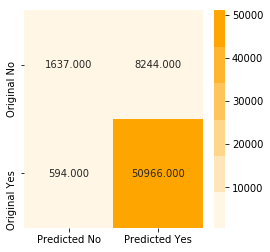

In [79]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

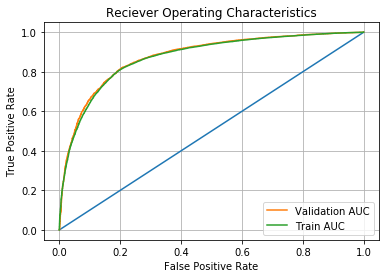

In [80]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using Grid Search CV</h3>

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l1',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(tfidf_train_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(tfidf_test_sent_vectors)
predict_y_train = optimized_clf.predict(tfidf_train_sent_vectors)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(tfidf_test_sent_vectors,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.8531444630107854
The best alpha(1/C) is  0.0001


In [87]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(tfidf_train_sent_vectors,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(tfidf_train_sent_vectors,Y_train)

predict_y_test = clf.predict(tfidf_test_sent_vectors)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(tfidf_test_sent_vectors)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(tfidf_train_sent_vectors)
probab_y_train = calibrated_model.predict_proba(tfidf_train_sent_vectors)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Tfidf weighted avg w2v vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Tfidf weighted avg w2v vectorized Linear SVM is 0.878


Confusion Matrix for train data
Confusion matrix


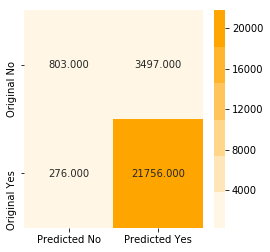

In [84]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


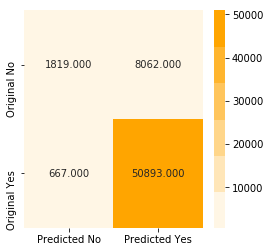

In [85]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

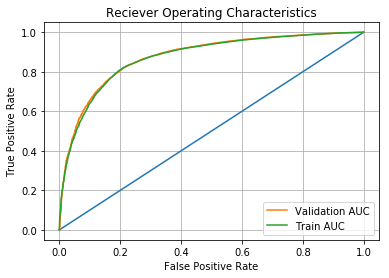

In [86]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>L2 Regularization</h3>

In [88]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l2',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(tfidf_train_sent_vectors,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(tfidf_train_sent_vectors)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


In [89]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l2',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(tfidf_train_sent_vectors):
        x_train = tfidf_train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = tfidf_train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|██████████| 9/9 [00:35<00:00,  3.53s/it]


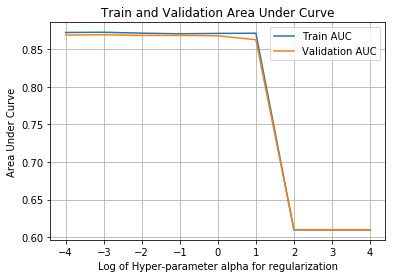

In [90]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [91]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l2',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(tfidf_train_sent_vectors,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(tfidf_train_sent_vectors,Y_train)

predict_y_test = clf.predict(tfidf_test_sent_vectors)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(tfidf_test_sent_vectors)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(tfidf_train_sent_vectors)
probab_y_train = calibrated_model.predict_proba(tfidf_train_sent_vectors)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Tfidf weighted avg w2v vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Tfidf weighted avg w2v vectorized Linear SVM is 0.875


Confusion Matrix for test data
Confusion matrix


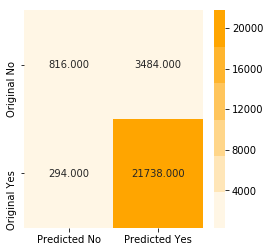

In [92]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


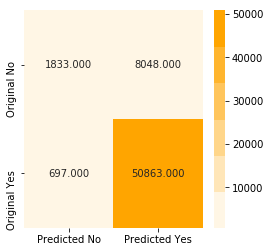

In [93]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

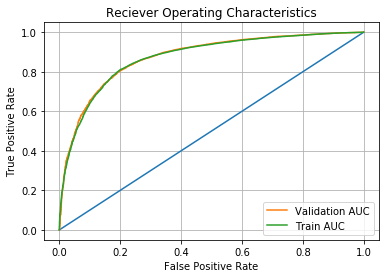

In [94]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using Grid Search CV</h3>

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l2',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(tfidf_train_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(tfidf_test_sent_vectors)
predict_y_train = optimized_clf.predict(tfidf_train_sent_vectors)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(tfidf_test_sent_vectors,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.8556509190338751
The best alpha(1/C) is  0.0001


In [97]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l2',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(tfidf_train_sent_vectors,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(tfidf_train_sent_vectors,Y_train)

predict_y_test = clf.predict(tfidf_test_sent_vectors)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(tfidf_test_sent_vectors)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(tfidf_train_sent_vectors)
probab_y_train = calibrated_model.predict_proba(tfidf_train_sent_vectors)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for Tfidf weighted avg w2v vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for Tfidf weighted avg w2v vectorized Linear SVM is 0.877


Confusion Matrix for test data
Confusion matrix


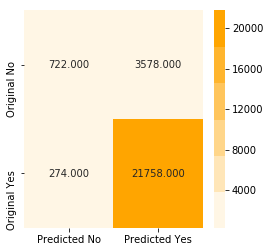

In [98]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


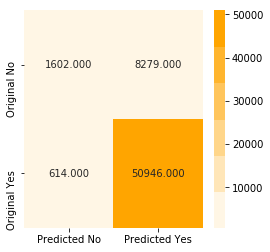

In [99]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

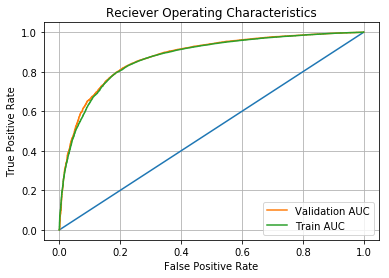

In [100]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Feature Engineering for Linear SVM</h3>

<h3>BoW vectorization is used</h3>
<h4>Using review length as a feature</h4>

In [33]:
# Calculating and storing length of each review in train data set, in an numpy array

train_review_len = np.zeros(len(X_train))
i=0
for sent in X_train:
    train_review_len[i] = len(sent)
    i += 1

print(train_review_len.shape)

(61441,)


In [34]:
# Calculating and storing length of each review in train data set, in an numpy array

test_review_len = np.zeros(len(X_test))
i=0
for sent in X_test:
    test_review_len[i] = len(sent)
    i += 1

print(test_review_len.shape)

(26332,)


In [35]:
# vectorizing train and test dataset using bow
bow_train_vect = bow_vect.fit_transform(X_train)
bow_test_vect = bow_vect.transform(X_test)

In [36]:
print(bow_train_vect.shape)

(61441, 46115)


In [37]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

# now we will add review length as a new feature to train  data set
# The shape of train_review_len is 254919 and hstack takes compatible matrices only 
# Making the train_review_len to bow_train_vect
A = coo_matrix([train_review_len]).T

bow_train_vect = hstack([bow_train_vect,A])
print(bow_train_vect.shape)

(61441, 46116)


In [38]:
# now we will add review length as a new feature to train  data set
# Since hstack takes compatible matrices only 
# Making the test_review_len to bow_test_vect
B = coo_matrix([test_review_len]).T
bow_test_vect = hstack([bow_test_vect,B])
print(bow_test_vect.shape)

(26332, 46116)


In [39]:
from scipy import sparse
# Converting bow_train_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
print(type(bow_train_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [40]:
# Doing same as above for test dataset
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [41]:
from sklearn.preprocessing import StandardScaler
# Initializing standard scaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

In [42]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l1',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(bow_train_vect,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [03:58<00:00, 10.45s/it]


In [43]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l2',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|██████████| 9/9 [00:45<00:00,  3.73s/it]


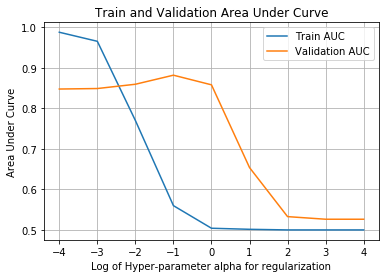

In [44]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [46]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.1,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(bow_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(bow_train_vect)
probab_y_train = calibrated_model.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for feature engineered BoW vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for feature engineered BoW vectorized Linear SVM is 0.546


For test dataset
Confusion matrix


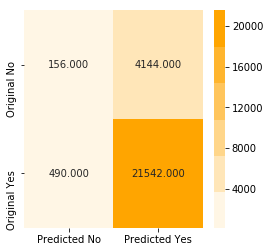

In [47]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset
Confusion matrix


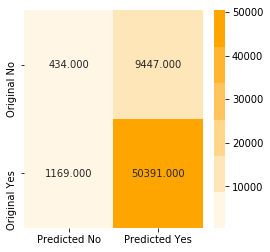

In [48]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

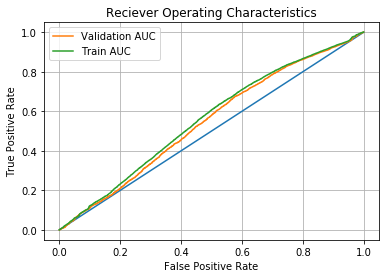

In [49]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using grid search cv</h3>

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l1',tol=0.001,max_iter=400)
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(bow_test_vect,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.8702339358954884
The best alpha(1/C) is  0.0001


In [51]:
# Taking best value of alpha = 0.0001 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(bow_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(bow_train_vect)
probab_y_train = calibrated_model.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for feature engineered BoW vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for feature engineered BoW vectorized Linear SVM is 0.892


For test dataset
Confusion matrix


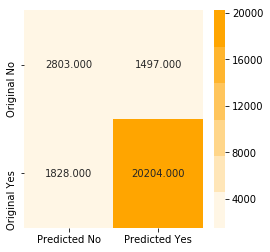

In [52]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset
Confusion matrix


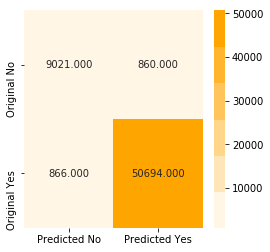

In [53]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

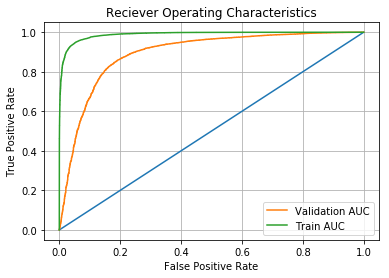

In [54]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h2>Using summary as a feature</h2>

In [42]:
# Splitting summary into train and test 
train_summ,test_summ,Y_train_summ,Y_test_summ = train_test_split(preprocessed_summary,Y,test_size=0.3,random_state=42)

In [43]:
# Using bag of words to vectorize summary
# For train dataset
count_vect = CountVectorizer()
train_vect = count_vect.fit_transform(train_summ)
print(train_vect.shape)

# for test dataset
test_vect = count_vect.transform(test_summ)
print(test_vect.shape)

(61441, 12239)
(26332, 12239)


In [44]:
# now we will add vectorized review as a new feature to train  data set
bow_train_vect = hstack([bow_train_vect,train_vect])
print(bow_train_vect.shape)

(61441, 58355)


In [45]:
# now we will add vectorized review as a new feature to train  data set
bow_test_vect = hstack([bow_test_vect,test_vect])
print(bow_test_vect.shape)

(26332, 58355)


In [46]:
# Converting tfidf_train_vect and tfidf_test_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_train_vect))
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [47]:
from sklearn.preprocessing import StandardScaler
# Initializing standard scaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

In [61]:
# Initializing the linear SVM classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np
from sklearn.calibration import CalibratedClassifierCV

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SGDClassifier(penalty='l1',alpha=i,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    calibrated_model.fit(bow_train_vect,Y_train)
    # evaluate the model
    probab_y = calibrated_model.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [04:58<00:00, 13.39s/it]


In [62]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SGDClassifier(penalty='l2',alpha=k,tol=0.001,max_iter=400)
    calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        calibrated_model.fit(x_train,y_train)
    
        probab_y = calibrated_model.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|██████████| 9/9 [00:52<00:00,  4.63s/it]


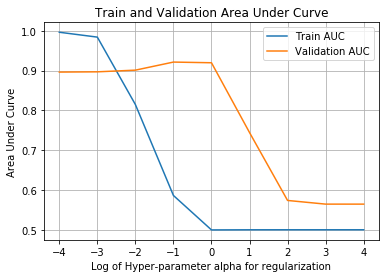

In [63]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [69]:
# Taking best value of alpha = 0.01 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(bow_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(bow_train_vect)
probab_y_train = calibrated_model.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for feature engineered BoW vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for feature engineered BoW vectorized Linear SVM is 0.933


For test dataset
Confusion matrix


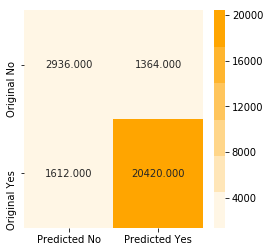

In [70]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset
Confusion matrix


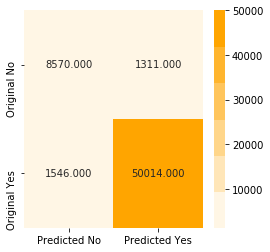

In [71]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

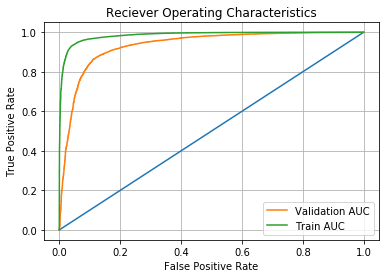

In [72]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Using Grid Search CV</h3>

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV


# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SGDClassifier(penalty='l1',tol=0.001,max_iter=400)

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
# Dictionary of parameters to be searched on 
parameters = {'alpha':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_alpha = grid_model.best_estimator_.alpha

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(bow_test_vect,Y_test))
print("The best alpha(1/C) is ",best_alpha)

The optimized model is SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=400, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)
Accuracy of best model is 0.8935135956250949
The best alpha(1/C) is  0.0001


In [53]:
# Taking best value of alpha = 0.01 an trainig final model
# Initializing model
clf = SGDClassifier(penalty='l1',alpha=0.0001,tol=0.001,max_iter=400)
calibrated_model = CalibratedClassifierCV(clf,method='sigmoid',cv=5)
# Training model on best value 
calibrated_model.fit(bow_train_vect,Y_train)

#Training SGDClassifier to get weight vectors as CalibratedClassifier dont have the attribute coef_ which returns weight vector.
clf.fit(bow_train_vect,Y_train)

predict_y_test = clf.predict(bow_test_vect)# Getting labels predicted by SGDClassifier instead of CalibratedClassifier.
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = calibrated_model.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(bow_train_vect)
probab_y_train = calibrated_model.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for feature engineered BoW vectorized Linear SVM is {:.3f}".format(auc))

Final AUC for feature engineered BoW vectorized Linear SVM is 0.930


For test dataset
Confusion matrix


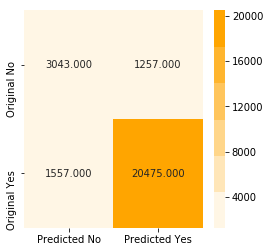

In [54]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset
Confusion matrix


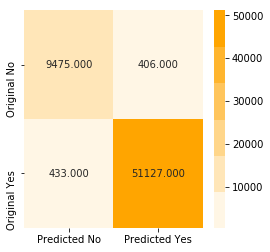

In [55]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

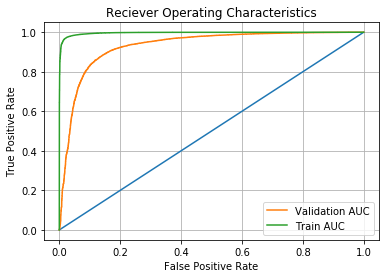

In [56]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [48]:
# Taking only 40k points for this section
rbf_final = final.sample(40000)

# Preprocessing reviews
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(rbf_final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:21<00:00, 1818.49it/s]


In [49]:
# Processing summary
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(rbf_final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:15<00:00, 2655.49it/s]


In [50]:
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Splitting data into train and test dataset
bow_vect = CountVectorizer(min_df=5,max_features=500)

X = preprocessed_reviews
Y = rbf_final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train))
print(len(X_test))

28000
12000


In [36]:
# Vectorizing train and test dataset seperately to prevent data lekage
bow_train_vect = bow_vect.fit_transform(X_train)
bow_test_vect = bow_vect.transform(X_test)
bow_train_vect.shape

(28000, 500)

In [37]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

In [38]:
# Initializing the linear SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SVC(C=i,tol=0.001,max_iter=-1,probability=True)
    clf.fit(bow_train_vect,Y_train)
    # evaluate the model
    probab_y = clf.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [3:50:02<00:00, 2074.69s/it]  


In [39]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=3)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SVC(C=k,tol=0.001,max_iter=-1,probability=True)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        probab_y = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|██████████| 9/9 [2:41:12<00:00, 1340.79s/it]


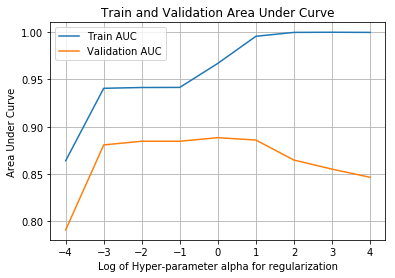

In [40]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

<h3>Using Grid Search CV</h3>

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SVC(tol=0.001,max_iter=-1,probability=True)
# Dictionary of parameters to be searched on 
parameters = {'C':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_c = grid_model.best_estimator_.C

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(bow_test_vect,Y_test))
print("The best alpha(1/C) is ",best_c)

The optimized model is SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of best model is 0.882
The best alpha(1/C) is  10


In [42]:
# Taking best value of alpha = 10 an trainig final model
# Initializing model
clf = SVC(C=10,tol=0.001,max_iter=-1,probability=True)
# Training model on best value 
clf.fit(bow_train_vect,Y_train)


predict_y_test = clf.predict(bow_test_vect)
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(bow_train_vect)
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] 
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for  BoW vectorized RBF SVM is {:.3f}".format(auc))

Final AUC for  BoW vectorized RBF SVM is 0.895


Confusion Matrix for test data
Confusion matrix


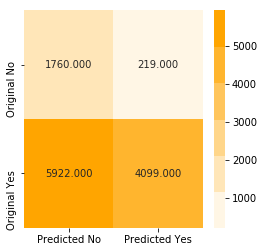

In [132]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


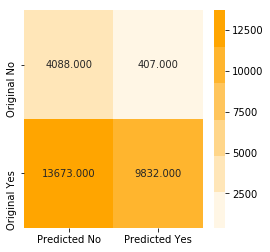

In [133]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

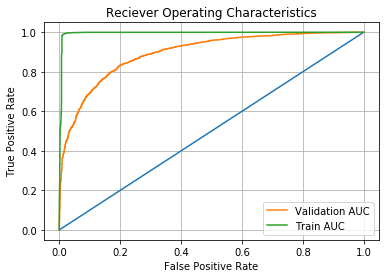

In [43]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [37]:
# Initializing tfidf vect
tfidf_vect = TfidfVectorizer(max_features=500)

# Vectorizing train and test dataset seperately to prevent data lekage
tfidf_train_vect = tfidf_vect.fit_transform(X_train)
tfidf_test_vect = tfidf_vect.transform(X_test)
tfidf_train_vect.shape

(28000, 500)

In [38]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
tfidf_train_vect = std.fit_transform(tfidf_train_vect)
tfidf_test_vect = std.transform(tfidf_test_vect)

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(max_features=500)
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:
# Initializing the linear SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SVC(C=i,tol=0.001,max_iter=-1,probability=True)
    clf.fit(tfidf_train_vect,Y_train)
    # evaluate the model
    probab_y = clf.predict_proba(tfidf_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|██████████| 9/9 [3:19:51<00:00, 1854.18s/it]


In [41]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=3)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SVC(C=k,tol=0.001,max_iter=-1,probability=True)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(tfidf_train_vect):
        x_train = tfidf_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = tfidf_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        probab_y = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|██████████| 9/9 [2:21:49<00:00, 1297.17s/it]


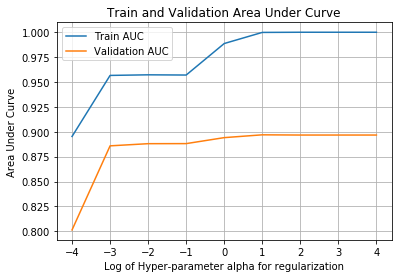

In [42]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

<h3>Using grid search cv</h3>

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SVC(tol=0.001,max_iter=-1,probability=True)
# Dictionary of parameters to be searched on 
parameters = {'C':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(tfidf_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_c = grid_model.best_estimator_.C

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(tfidf_test_vect)
predict_y_train = optimized_clf.predict(tfidf_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(tfidf_test_vect,Y_test))
print("The best alpha(1/C) is ",best_c)

The optimized model is SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of best model is 0.89225
The best alpha(1/C) is  10


In [44]:
# Taking best value of alpha = 1 an trainig final model
# Initializing model
clf = SVC(C=10,tol=0.001,max_iter=-1,probability=True)
# Training model on best value 
clf.fit(tfidf_train_vect,Y_train)


predict_y_test = clf.predict(tfidf_test_vect)
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = clf.predict_proba(tfidf_test_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(tfidf_train_vect)
probab_y_train = clf.predict_proba(tfidf_train_vect)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for  Tfidf vectorized RBF SVM is {:.3f}".format(auc))

Final AUC for  Tfidf vectorized RBF SVM is 0.909


Confusion Matrix for test data
Confusion matrix


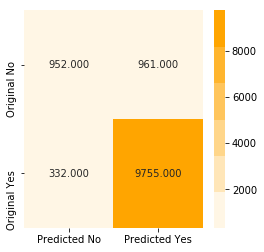

In [46]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


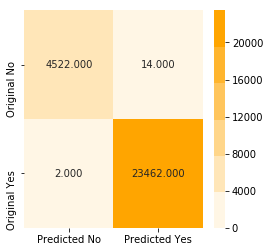

In [47]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

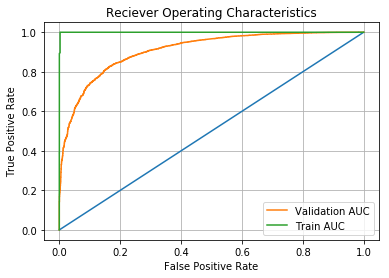

In [48]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [31]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [32]:
# Train your own Word2Vec model using your own text corpus
list_train=[]
for sentance in tqdm(X_train):
    list_train.append(sentance.split())

# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

100%|████████████████████████████████████████████████████████████████████████| 61441/61441 [00:00<00:00, 105075.31it/s]


[('awesome', 0.8333090543746948), ('fantastic', 0.8322309255599976), ('good', 0.8180323243141174), ('excellent', 0.8043140172958374), ('wonderful', 0.7865221500396729), ('perfect', 0.7813515067100525), ('terrific', 0.7596462368965149), ('amazing', 0.7254059910774231), ('nice', 0.6992887258529663), ('decent', 0.6784538626670837)]
[('greatest', 0.8098580241203308), ('best', 0.7293096780776978), ('nastiest', 0.6874908804893494), ('tastiest', 0.650694727897644), ('smoothest', 0.6456950902938843), ('experienced', 0.6386241912841797), ('disgusting', 0.608429491519928), ('closest', 0.6018320322036743), ('terrible', 0.599880576133728), ('horrible', 0.5935107469558716)]


In [33]:
w2v_words = list(w2v_model.wv.vocab)

In [34]:
list_of_sentance=[]
for sentance in tqdm(preprocessed_reviews):
    list_of_sentance.append(sentance.split())

100%|█████████████████████████████████████████████████████████████████████████| 40000/40000 [00:00<00:00, 87391.85it/s]


In [35]:
# Splitting list_of_sentance into train and test dataset
Y = rbf_final['Score']
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentance,Y,test_size=0.3,random_state=42)
print(len(X_train))

28000


In [36]:
# Vectorizing train datset. 
# Train and test dataset are vectorized seperately to prevent d lekage 
# average Word2Vec
# compute average word2vec for each review.
train_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_avg_w2v.append(sent_vec)
print(len(train_avg_w2v))
print(len(train_avg_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [01:19<00:00, 352.34it/s]


28000
50


In [37]:
# Vectorizing test datset. 
# Train and test dataset are vectorized seperately to prevent d lekage 
# average Word2Vec
# compute average word2vec for each review.
test_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_avg_w2v.append(sent_vec)
print(len(test_avg_w2v))
print(len(test_avg_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:31<00:00, 381.71it/s]


12000
50


In [38]:
# Initializing the linear SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SVC(C=i,tol=0.001,max_iter=-1,probability=True)
    clf.fit(train_avg_w2v,Y_train)
    # evaluate the model
    probab_y = clf.predict_proba(train_avg_w2v)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [4:07:38<00:00, 3586.11s/it]


In [39]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=3)

# In this section we will perform 3-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SVC(C=k,tol=0.001,max_iter=-1,probability=True)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_avg_w2v):
        x_train = train_avg_w2v[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_avg_w2v[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        probab_y = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [1:33:15<00:00, 1275.66s/it]


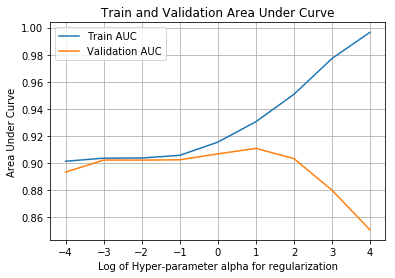

In [40]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

<h3>Using grid search cv</h3>

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SVC(tol=0.001,max_iter=-1,probability=True)
# Dictionary of parameters to be searched on 
parameters = {'C':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(train_avg_w2v,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_c = grid_model.best_estimator_.C

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(test_avg_w2v)
predict_y_train = optimized_clf.predict(train_avg_w2v)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(test_avg_w2v,Y_test))
print("The best alpha(1/C) is ",best_c)

The optimized model is SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of best model is 0.8826666666666667
The best alpha(1/C) is  1000


In [44]:
# Taking best value of alpha = 1000 an trainig final model
# Initializing model
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
clf = SVC(C=1000,tol=0.001,max_iter=-1,probability=True)
# Training model on best value 
clf.fit(train_avg_w2v,Y_train)


predict_y_test = clf.predict(test_avg_w2v)
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = clf.predict_proba(test_avg_w2v)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(train_avg_w2v)
probab_y_rain = clf.predict_proba(train_avg_w2v)[:,1] # Returns probability for positive class.
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for avg W2v vectorized RBF SVM is {:.3f}".format(auc))

Final AUC for avg W2v vectorized RBF SVM is 0.892


Confusion Matrix for test data
Confusion matrix


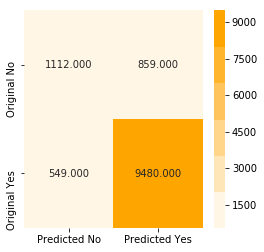

In [45]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


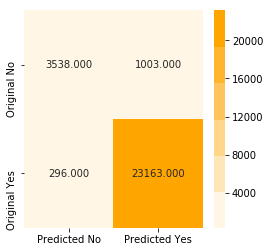

In [46]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

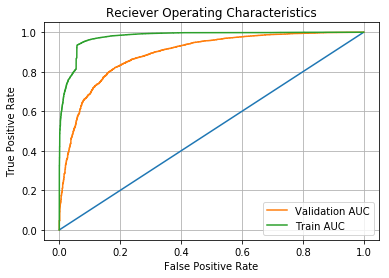

In [47]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_rain)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [51]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(max_features=500)
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [52]:
# Train your own Word2Vec model using your own text corpus
list_train=[]
for sentance in tqdm(X_train):
    list_train.append(sentance.split())

# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

100%|████████████████████████████████████████████████████████████████████████| 28000/28000 [00:00<00:00, 142940.36it/s]


[('good', 0.7894672751426697), ('fantastic', 0.7849023938179016), ('awesome', 0.7762706875801086), ('amazing', 0.7562480568885803), ('excellent', 0.7468611001968384), ('wonderful', 0.7382209300994873), ('perfect', 0.7136945724487305), ('terrific', 0.6869280934333801), ('nice', 0.638320803642273), ('especially', 0.6370732188224792)]
[('nastiest', 0.7969458103179932), ('greatest', 0.767988383769989), ('best', 0.760701596736908), ('smoothest', 0.7598435878753662), ('closest', 0.7439322471618652), ('tastiest', 0.7093961834907532), ('ever', 0.7078883647918701), ('honestly', 0.7031714916229248), ('experienced', 0.7024039030075073), ('disgusting', 0.6906024217605591)]


In [53]:
w2v_words = list(w2v_model.wv.vocab)

In [54]:
list_of_sentance=[]
for sentance in tqdm(preprocessed_reviews):
    list_of_sentance.append(sentance.split())

100%|████████████████████████████████████████████████████████████████████████| 40000/40000 [00:00<00:00, 152759.14it/s]


In [55]:
X_train,X_test,Y_train,Y_test = train_test_split(list_of_sentance,Y,test_size=0.3,random_state=42)
print(len(X_train))

28000


In [56]:
# TF-IDF weighted Word2Vec for test
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [01:23<00:00, 336.87it/s]


In [57]:
# TF-IDF weighted Word2Vec for test dataset
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += 1
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:36<00:00, 325.64it/s]


In [58]:
# Initializing the linear SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SVC(C=i,tol=0.001,max_iter=-1,probability=True)
    clf.fit(tfidf_train_sent_vectors,Y_train)
    # evaluate the model
    probab_y = clf.predict_proba(tfidf_train_sent_vectors)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [1:26:38<00:00, 1101.68s/it]


In [59]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=3)

# In this section we will perform 3-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # RBF SVM classifier
    clf = SVC(C=k,tol=0.001,max_iter=-1,probability=True)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(tfidf_train_sent_vectors):
        x_train = tfidf_train_sent_vectors[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = tfidf_train_sent_vectors[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        probab_y = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
        
    cv_auc_list.append(auc/i) # Storing AUC value

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:03:05<00:00, 783.30s/it]


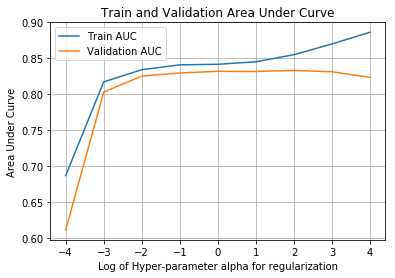

In [60]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

<h3>Using Grid Search CV</h3>

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SVC(tol=0.001,max_iter=-1,probability=True)
# Dictionary of parameters to be searched on 
parameters = {'C':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(tfidf_train_sent_vectors,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_
best_c = grid_model.best_estimator_.C

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(tfidf_test_sent_vectors)
predict_y_train = optimized_clf.predict(tfidf_train_sent_vectors)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(tfidf_test_sent_vectors,Y_test))
print("The best alpha(1/C) is ",best_c)

The optimized model is SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of best model is 0.8540833333333333
The best alpha(1/C) is  10000


In [63]:
# Taking best value of alpha = 1000 an trainig final model
# Initializing model
clf = SVC(C=10000,tol=0.001,max_iter=-1,probability=True)
# Training model on best value 
clf.fit(tfidf_train_sent_vectors,Y_train)


predict_y_test = clf.predict(tfidf_test_sent_vectors)
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = clf.predict_proba(tfidf_test_sent_vectors)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(tfidf_train_sent_vectors)
probab_y_train = clf.predict_proba(tfidf_train_sent_vectors)[:,1]
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for  Tfidf weighted w2v vectorized RBF SVM is {:.3f}".format(auc))

Final AUC for  Tfidf weighted w2v vectorized RBF SVM is 0.840


Confusion Matrix for test data
Confusion matrix


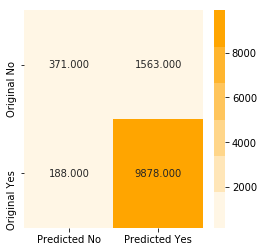

In [64]:
# Plotting confusion matrix
print("Confusion Matrix for test data")
confusion_matrix_plot(Y_test,predict_y_test)

Confusion Matrix for train data
Confusion matrix


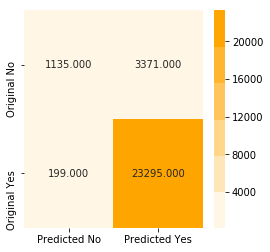

In [65]:
# Plotting confusion matrix
print("Confusion Matrix for train data")
confusion_matrix_plot(Y_train,predict_y_train)

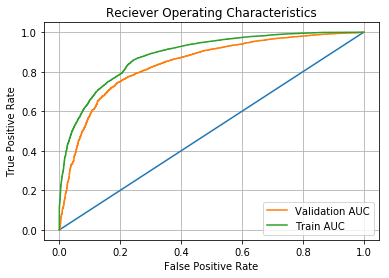

In [67]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Feature Engineering on BoW Vectorizer</h3>

<h3>Using review length as a feature</h3>

In [68]:
# Splitting summary into train and test 
Y = rbf_final['Score']
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)

In [69]:
# For reviews train and test dataset
count_vect = CountVectorizer(max_features=500)
# For train dataset
bow_train_vect = count_vect.fit_transform(X_train)
print(bow_train_vect.shape)

# For test dataset
bow_test_vect = count_vect.fit_transform(X_test)
print(bow_test_vect.shape)

(28000, 500)
(12000, 500)


In [70]:
# Calculating and storing length of each review in train data set, in an numpy array

train_review_len = np.zeros(len(X_train))
i=0
for sent in X_train:
    train_review_len[i] = len(sent)
    i += 1

print(train_review_len.shape)

(28000,)


In [71]:
# Calculating and storing length of each review in train data set, in an numpy array

test_review_len = np.zeros(len(X_test))
i=0
for sent in X_test:
    test_review_len[i] = len(sent)
    i += 1

print(test_review_len.shape)

(12000,)


In [72]:
print(bow_train_vect.shape)
print(bow_test_vect.shape)

(28000, 500)
(12000, 500)


In [73]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

# now we will add review length as a new feature to train  data set
# The shape of train_review_len is 254919 and hstack takes compatible matrices only 
# Making the train_review_len to bow_train_vect
A = coo_matrix([train_review_len]).T

bow_train_vect = hstack([bow_train_vect,A])
print(bow_train_vect.shape)

(28000, 501)


In [74]:
# now we will add review length as a new feature to train  data set
# Since hstack takes compatible matrices only 
# Making the test_review_len to bow_test_vect
B = coo_matrix([test_review_len]).T
bow_test_vect = hstack([bow_test_vect,B])
print(bow_test_vect.shape)

(12000, 501)


In [75]:
from scipy import sparse
# Converting bow_train_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
print(type(bow_train_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [76]:
# Doing same as above for test dataset
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [77]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

In [78]:
# Initializing the linear SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SVC(C=i,tol=0.001,max_iter=-1,probability=True)
    clf.fit(bow_train_vect,Y_train)
    # evaluate the model
    probab_y = clf.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [3:37:43<00:00, 1912.58s/it]


In [79]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SVC(C=k,tol=0.001,max_iter=-1,probability=True)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        probab_y = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [8:39:13<00:00, 4612.77s/it]


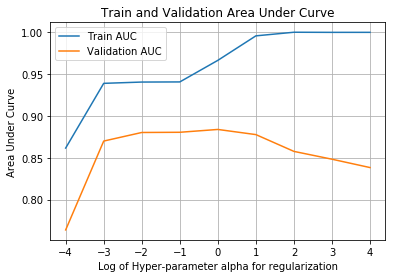

In [80]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SVC(tol=0.001,max_iter=-1,probability=True)
# Dictionary of parameters to be searched on 
parameters = {'C':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)



GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=0)

In [85]:
# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)


print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(bow_test_vect,Y_test))

The optimized model is SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of best model is 0.8289166666666666


In [92]:
# Taking best value of alpha = 1 an trainig final model
# Initializing model
clf = SVC(C=100,tol=0.001,max_iter=-1,probability=True)
# Training model on best value 
clf.fit(bow_train_vect,Y_train)


predict_y_test = clf.predict(bow_test_vect)
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] 
predict_y_train = clf.predict(bow_train_vect)
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for feature engineered BoW vectorized RBF SVM is {:.3f}".format(auc))

Final AUC for feature engineered BoW vectorized RBF SVM is 0.756


For test dataset
Confusion matrix


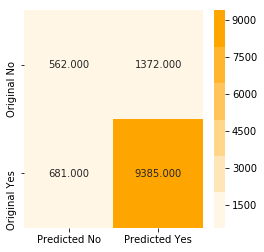

In [93]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset
Confusion matrix


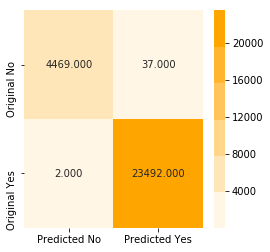

In [94]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

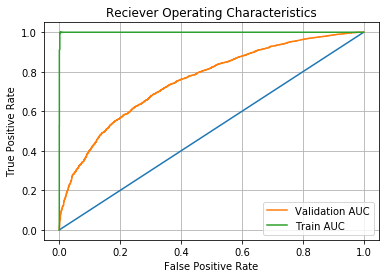

In [95]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

<h3>Bow Summary as a feature</h3>

In [96]:
# Splitting summary into train and test 
Y = rbf_final['Score']
X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,Y,test_size=0.3,random_state=42)
train_summ,test_summ,Y_train_summ,Y_test_summ = train_test_split(preprocessed_summary,Y,test_size=0.3,random_state=42)

In [98]:
# For reviews train and test dataset
count_vect = CountVectorizer(max_features=500)
# For train dataset
bow_train_vect = count_vect.fit_transform(X_train)
print(bow_train_vect.shape)

# For test dataset
bow_test_vect = count_vect.transform(X_test)
print(bow_test_vect.shape)

(28000, 500)
(12000, 500)


In [99]:
# Using bag of words to vectorize summary
# For train dataset
count_vect = CountVectorizer(max_features=200)
# For train dataset
train_vect = count_vect.fit_transform(train_summ)
print(train_vect.shape)

# for test dataset
test_vect = count_vect.transform(test_summ)
print(test_vect.shape)

(28000, 200)
(12000, 200)


In [100]:
# now we will add vectorized review as a new feature to train  data set
bow_train_vect = hstack([bow_train_vect,train_vect])
print(bow_train_vect.shape)

(28000, 700)


In [101]:
# now we will add vectorized review as a new feature to train  data set
bow_test_vect = hstack([bow_test_vect,test_vect])
print(bow_test_vect.shape)

(12000, 700)


In [102]:
# Converting bow_train_vect and bow_test_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_train_vect))
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [103]:
# Standarizing data
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=False)
bow_train_vect = std.fit_transform(bow_train_vect)
bow_test_vect = std.transform(bow_test_vect)

C:\Users\rites\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rites\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rites\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [104]:
# Initializing the linear SVM classifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
import numpy as np

param_alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000] 
train_auc_list = [] # Will contain train auc score for various lambda

# Calculating AUC on train dataset .
for i in tqdm(param_alpha):
    clf = SVC(C=i,tol=0.001,max_iter=-1,probability=True)
    clf.fit(bow_train_vect,Y_train)
    # evaluate the model
    probab_y = clf.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class points
    auc = roc_auc_score(Y_train,probab_y)
    train_auc_list.append(auc)

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [3:07:10<00:00, 1602.65s/it]


In [105]:
from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

# In this section we will perform 10-fold Cross validation on timse series split data

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(param_alpha):
    # Linear SVM classifier
    clf = SVC(C=k,tol=0.001,max_iter=-1,probability=True)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        probab_y = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,probab_y)
    cv_auc_list.append(auc/i) # Storing AUC value

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [7:10:57<00:00, 3455.47s/it]


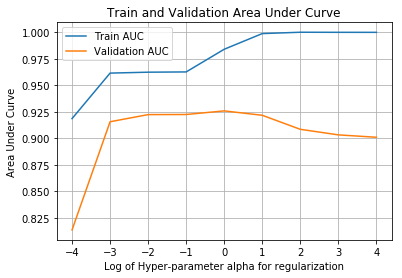

In [106]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

<h3>Using Grid Search CV</h3>

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = SVC(tol=0.001,max_iter=-1,probability=True)
# Dictionary of parameters to be searched on 
parameters = {'C':param_alpha}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=3,refit=True,scoring=auc_score,n_jobs=-1)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=0)

In [110]:
# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

#predict_probab = optimized_clf.predict_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y_test = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)
probab_y_test = optimized_clf.predict_proba(bow_test_vect)[:,1]
auc = roc_auc_score(Y_test,probab_y_test)

print("The optimized model is",optimized_clf)
print("Accuracy of best model is",optimized_clf.score(bow_test_vect,Y_test))
print("Auc of best model is {:.3f}".format(auc))

The optimized model is SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of best model is 0.8768333333333334
Auc of best model is 0.873


In [111]:
# Taking best value of alpha = 1 for trainig final model
# Initializing model
clf = SVC(C=10,tol=0.001,max_iter=-1,probability=True)
# Training model on best value 
clf.fit(bow_train_vect,Y_train)


predict_y_test = clf.predict(bow_test_vect)
# Getting probability values from CalibratedClassifier as SGDClassifier dont have method predict_proba().
probab_y_test = clf.predict_proba(bow_test_vect)[:,1] # Returns probability for positive class.
probab_y_train = clf.predict_proba(bow_train_vect)[:,1] # Returns probability for positive class.
predict_y_train = clf.predict(bow_train_vect)
auc = roc_auc_score(Y_test,probab_y_test)
print("Final AUC for feature engineered BoW vectorized RBF SVM is {:.3f}".format(auc))

Final AUC for feature engineered BoW vectorized RBF SVM is 0.873


For test dataset
Confusion matrix


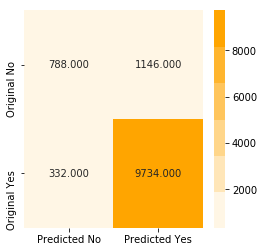

In [112]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y_test)

For train dataset
Confusion matrix


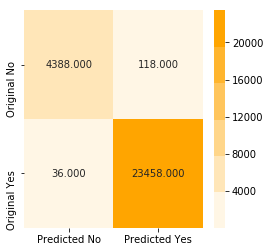

In [113]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

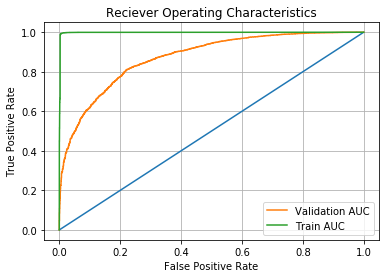

In [114]:
#Plotting ROC Curve
plot_roc_curve(Y_test,probab_y_test,Y_train,probab_y_train)

# [6] Conclusions

In [117]:
from prettytable import PrettyTable

# Initializing table object
print("For Linear SVM")
x = PrettyTable()

x.field_names = ["Vectorizer","Model","Hyper-Parameter alpha","Area Under Curve"]

x.add_row([ "Bow","Linear SVM L1 regularized","0.0001","0.893" ])
x.add_row([ "Bow","Linear SVM L2 regularized","0.1","0.905" ])
x.add_row([ "Tfidf","Linear SVM L1 regularized","0.0001","0.897" ])
x.add_row([ "Tfidf","Linear SVM L2 regularized","0.1","0.912" ])
x.add_row([ "AvgW2V","Linear SVM L1 regularized","0.0001","0.928" ])
x.add_row([ "AvgW2V","Linear SVM L2 regularized","0.0001","0.928" ])
x.add_row([ "Tfidf weighted W2V","Linear SVM L1 regularized","0.0001","0.878" ])
x.add_row([ "Tfidf weighted W2V","Linear SVM L2 regularized","0.0001","0.877" ])
x.add_row([ "Bow with review length ","Linear SVM L1 regularized","0.0001","0.892" ])
x.add_row([ "Bow with summary feature","Linear SVM L1 regularized","0.0001","0.930" ])

print(x)

For Linear SVM
+--------------------------+---------------------------+-----------------------+------------------+
|        Vectorizer        |           Model           | Hyper-Parameter alpha | Area Under Curve |
+--------------------------+---------------------------+-----------------------+------------------+
|           Bow            | Linear SVM L1 regularized |         0.0001        |      0.893       |
|           Bow            | Linear SVM L2 regularized |          0.1          |      0.905       |
|          Tfidf           | Linear SVM L1 regularized |         0.0001        |      0.897       |
|          Tfidf           | Linear SVM L2 regularized |          0.1          |      0.912       |
|          AvgW2V          | Linear SVM L1 regularized |         0.0001        |      0.928       |
|          AvgW2V          | Linear SVM L2 regularized |         0.0001        |      0.928       |
|    Tfidf weighted W2V    | Linear SVM L1 regularized |         0.0001        |     

In [116]:
from prettytable import PrettyTable

# Initializing table object
print("For RBF Kernel SVM")
x = PrettyTable()

x.field_names = ["Vectorizer","Model","Hyper-Parameter C","Area Under Curve"]

x.add_row([ "Bow","RBF SVM ","10","0.895" ])
x.add_row([ "Tfidf","RBF SVM","10","0.909" ])
x.add_row([ "AvgW2V","RBF SVM ","1000","0.892" ])
x.add_row([ "Tfidf weighted W2V","RBF SVM ","10000","0.840" ])
x.add_row([ "Bow with review length ","RBF SVM ","100","0.756" ])
x.add_row([ "Bow with summary feature","RBF SVM ","10","0.873" ])

print(x)

For RBF Kernel SVM
+--------------------------+----------+-------------------+------------------+
|        Vectorizer        |  Model   | Hyper-Parameter C | Area Under Curve |
+--------------------------+----------+-------------------+------------------+
|           Bow            | RBF SVM  |         10        |      0.895       |
|          Tfidf           | RBF SVM  |         10        |      0.909       |
|          AvgW2V          | RBF SVM  |        1000       |      0.892       |
|    Tfidf weighted W2V    | RBF SVM  |       10000       |      0.840       |
| Bow with review length   | RBF SVM  |        100        |      0.756       |
| Bow with summary feature | RBF SVM  |         10        |      0.873       |
+--------------------------+----------+-------------------+------------------+


<h2>Explaination </h2>
<h4>Data was cleaned and then we split data into train and test dataset with 70:30 ratio.</h4>
<h4>Train and test dataset were vectorized using fit_transform and transform methods to prevent data lekage.</h4>
<h4>We wrote our own for loops to to hyper parameter tunning by potting the train and cross validation AUC and then selecting the hyper-parameter corresponding to best cross-validation AUC.</h4>
<h4>In Linear SVM trained on BoW vectorization the model in which l2 regularization was used performed better than l1 regularized model.</h4>
<h4>To get the AUC Score for linear SVM we used calibrated classifier and to print top 10 features we used linear SGD with hinge loss as penalty.</h4>
<h4>To print top 10 positive features we arranged the weight vectors in ascending order using argsort and took the features corresponding to last 10 indexes. For top 10 negative features features corresponding to top 10 indexes were printed.</h4>
<h4>In feature engineering section we used review length and bag of words vectorization of summary and concatenated it with our reviews vectors using hstack but this could not improve our AUC.</h4>
<h4>Feature engineering did not improved the AUC of linear SVM.</h4>
<h4>The linear SVM model trained on bow feature engineered with summary as a feature gave the best AUC of 0.930</h4>
<h4>Linear SVM models performed better than RBF kernal SVM models.</h4>
<h4>Linear SVM models had an AUC as high as 0.930 and highest AUC for RBF SVM was 0.909</h4>
<h4>Feature engineering did improved the AUC for RBF kernel SVM.</h4>